## 16种评估指标
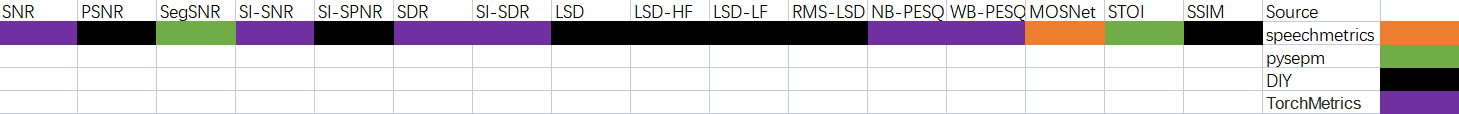

In [1]:
import numpy as np
import librosa

import speechmetrics as sm
import torch
from torchmetrics import SignalNoiseRatio
from torchmetrics import ScaleInvariantSignalNoiseRatio
from torchmetrics.audio import SignalDistortionRatio
from torchmetrics import ScaleInvariantSignalDistortionRatio
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
import pysepm

In [2]:
window =  np.inf
EPS = 1e-12
mosnet = sm.load(['absolute'],window)

snr = SignalNoiseRatio()
si_snr = ScaleInvariantSignalNoiseRatio()
sdr = SignalDistortionRatio()
si_sdr = ScaleInvariantSignalDistortionRatio()
nb_pesq = PerceptualEvaluationSpeechQuality(8000, 'nb')
wb_pesq = PerceptualEvaluationSpeechQuality(16000, 'wb')

seg_snr = pysepm.SNRseg
stoi = pysepm.stoi

import math
def psnr(original, noise):
    mse = np.mean((original - noise) ** 2) 
    psnr = 10 * math.log10(1 / mse) 
    return psnr

# F domain from https://github.com/haoheliu/voicefixer_main/blob/main/evaluation_proc/metrics.py
def wav_to_spectrogram(wav, rate=44100):
    hop_length = rate//100
    n_fft = 2048
    f = np.abs(librosa.stft(wav, hop_length=hop_length, n_fft=n_fft))
    f = np.transpose(f,(1,0))
    f = torch.tensor(f[None,None,...])
    return f

def energy_unify(estimated, original):
    
    target = pow_norm(estimated, original) * original
    target /= pow_p_norm(original) + EPS
    return estimated, target

def pow_norm(s1, s2):
    shape = list(s1.size())
    dimension = []
    for i in range(len(shape)):
        if(i == 0 or i == 1):continue
        dimension.append(i)
    return torch.sum(s1 * s2, dim=dimension, keepdim=True)

def pow_p_norm(signal):
    """Compute 2 Norm"""
    shape = list(signal.size())
    dimension = []
    for i in range(len(shape)):
        if(i == 0):continue
        dimension.append(i)
    return torch.pow(torch.norm(signal, p=2, dim=dimension, keepdim=True), 2)

def si_spnr(est, target):
    # in log scale
    output, target = energy_unify(est, target)
    noise = output - target
    # print(pow_p_norm(target) , pow_p_norm(noise), pow_p_norm(target) / (pow_p_norm(noise) + EPS))
    sp_loss = 10 * torch.log10((pow_p_norm(target) / (pow_p_norm(noise) + EPS) + EPS))
    return (torch.sum(sp_loss) / sp_loss.size()[0])

def lsd(est, target):# also LSD-LF,LSD-HF
    # in non-log scale
    lsd = torch.log10((target**2/((est + EPS)**2)) + EPS)**2
    lsd = torch.mean(torch.mean(lsd,dim=3)**0.5,dim=2)
    return lsd

def rms_lsd(est, target):
    # in non-log scale
    lsd1 = 10*torch.log10(est**2 + EPS)
    lsd2 = 10*torch.log10(target**2 + EPS)
    lsd = torch.mean(torch.mean((lsd1-lsd2)**2,dim=3)**0.5,dim=2)
    return lsd

from skimage.metrics import structural_similarity
def ssim(est, target):
    if("cuda" in str(target.device)):
        target, output = target.detach().cpu().numpy(), est.detach().cpu().numpy()
    else:
        target, output = target.numpy(), est.numpy()
    res = np.zeros([output.shape[0],output.shape[1]])
    for bs in range(output.shape[0]):
        for c in range(output.shape[1]):
            res[bs,c] = structural_similarity(output[bs,c,...],target[bs,c,...],win_size=7)
    return res

Loaded  speechmetrics.absolute.mosnet
Loaded  speechmetrics.absolute.srmr


D:\tools\conda\envs\audiosr\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ScaleInvariantSignalNoiseRatio). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
D:\tools\conda\envs\audiosr\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a n

In [3]:
def get_scores(target,preds,fs=16000):
    if target.size == 0: return False
    preds_ts = torch.tensor(preds)
    target_ts = torch.tensor(target)
    preds_sp = wav_to_spectrogram(preds, rate=fs)
    target_sp = wav_to_spectrogram(target, rate=fs)
    print("snr:",float(snr(preds_ts.clone(),target_ts.clone())))
    print("psnr:",float(psnr(preds,target)))
    print("segsnr:",float(seg_snr(preds,target,fs=fs)))
    print("sisnr:",float(si_snr(preds_ts.clone(),target_ts.clone())))
    print("sipsnr:",float(si_spnr(preds_sp.clone(), target_sp.clone())))
    print("sdr:",float(sdr(preds_ts.clone(),target_ts.clone())))
    print("sisdr:",float(si_sdr(preds_ts.clone(),target_ts.clone())))
    print("lsd:",float(lsd(preds_sp.clone(), target_sp.clone())))
    print("lsdhf:",float(lsd(preds_sp.clone()[...,1024//2:], target_sp.clone()[...,1024//2:])))#高频LSD-HF
    print("lsdlf:",float(lsd(preds_sp.clone()[...,:1024//2], target_sp.clone()[...,:1024//2])))#低频LSD-LF
    print("nbpesq:",float(nb_pesq(preds_ts.clone(),target_ts.clone())))
    print("wbpesq:",float(wb_pesq(preds_ts.clone(),target_ts.clone())))
    print("mosnet:",float(mosnet(preds, rate=fs)["mosnet"]))
    print("stoi:",float(stoi(preds,target,fs_sig=fs)))
    print("ssim:",float(ssim(preds_sp.clone(),target_sp.clone())))

In [4]:
reference = 'p361_056_high.wav'
predict = 'p361_056_VF.wav'
target, _ = librosa.load(reference, sr=16000)
preds, _ = librosa.load(predict, sr=16000)
get_scores(target,preds)

snr: -2.2471251487731934
psnr: 26.307268239145507
segsnr: -1.118975835256404
sisnr: -49.53632736206055
sipsnr: 7.682807922363281
sdr: 2.988051414489746
sisdr: -49.53471374511719
lsd: 0.963241457939148
lsdhf: 1.0245888233184814
lsdlf: 0.8849003911018372
nbpesq: 2.635087490081787
wbpesq: 2.557596206665039
mosnet: 4.267416000366211
stoi: 0.8256386966648248
ssim: 0.7453450003273551


## For Voice & Unvoice

In [5]:
target_V, index = librosa.effects.trim(target)
preds_V = preds[index[0]:index[1]]
target_U = np.append(target[:index[0]], target[index[1]:])
preds_U = np.append(preds[:index[0]], preds[index[1]:])

In [6]:
get_scores(target_V,preds_V)

snr: -2.2471251487731934
psnr: 26.307268239145507
segsnr: -1.118975835256404
sisnr: -49.53632736206055
sipsnr: 7.682807922363281
sdr: 2.988051414489746
sisdr: -49.53471374511719
lsd: 0.963241457939148
lsdhf: 1.0245888233184814
lsdlf: 0.8849003911018372
nbpesq: 2.635087490081787
wbpesq: 2.557596206665039
mosnet: 4.267416000366211
stoi: 0.8256386966648248
ssim: 0.7453450003273551


In [7]:
get_scores(target_U,preds_U)

False